In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100


In [4]:
wx = pd.read_csv('../data/wx/wx-frontier-agg.csv')
wx.head()

,INDEX,YEAR,GSP,GDD,GSTmax,GSTmin,frost,summer,HWI,CWI,dry,wet,PRCP95P
0,0,1941,3.869512,1555.1,25.865244,13.099390,2,94,11,7,13,5,4
1,1,1942,3.379878,1327.1,24.226220,11.957927,6,81,7,12,15,3,5
2,2,1943,3.396341,1303.8,23.991463,11.908537,7,80,6,7,10,4,2
3,3,1944,3.342331,1467.1,24.992073,12.899390,4,91,12,13,15,6,2
4,4,1945,3.471951,1130.0,23.137195,10.643293,6,66,5,13,19,3,5


In [5]:
ag = pd.read_csv('../data/agri/frontiers/Processed_Iowa+Cerro+Gordo_1960+2009_Annual+Crop.csv')
ag.head()

,Program,Year,Period,Geo Level,State,Ag District,County,Commodity,Data Item,Domain Category,Value
0,SURVEY,2015,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,196.9
1,SURVEY,2015,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,58.9
2,SURVEY,2014,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,168.3
3,SURVEY,2014,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,50.2
4,SURVEY,2013,YEAR,COUNTY,IOWA,NORTH CENTRAL,CERRO GORDO,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",NOT SPECIFIED,163.1


In [6]:
corn = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'CORN')].copy()
beans = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'SOYBEANS')].copy()

corn['YEAR'] = corn.Year
beans['YEAR'] = beans.Year

corn['Value'] = corn.Value.astype('float')
beans['Value'] = beans.Value.astype('float')

corn = corn[['YEAR', 'Value']]
beans = beans[['YEAR', 'Value']]

corn.head()

,YEAR,Value
0,2015,196.9
2,2014,168.3
4,2013,163.1
6,2012,124.8
8,2011,169.3


In [ ]:
    x = np.arange(len(algs))
    fig, ax = plt.subplots()
    rects = []
    width = 0.25
    for n, d in enumerate(errdata):
        rects.append(ax.bar(x - (width * (n-1)), d, width, label=sims[n][1]))
    ax.set_ylabel(err.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(algs)
    ax.legend(loc='lower right')

    for (i, r) in enumerate(rects):
        for (j, p) in enumerate(r.patches):
            px = p.get_x()
            pw = p.get_width()
            h = errdata[i][j]
            ax.text(px + pw / 2, h, '%6.3f' % h, ha='center', va='bottom')
    fig.tight_layout()


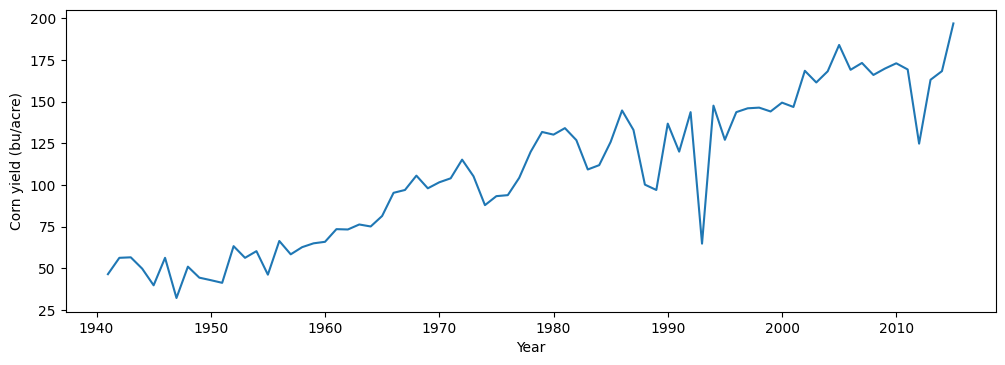

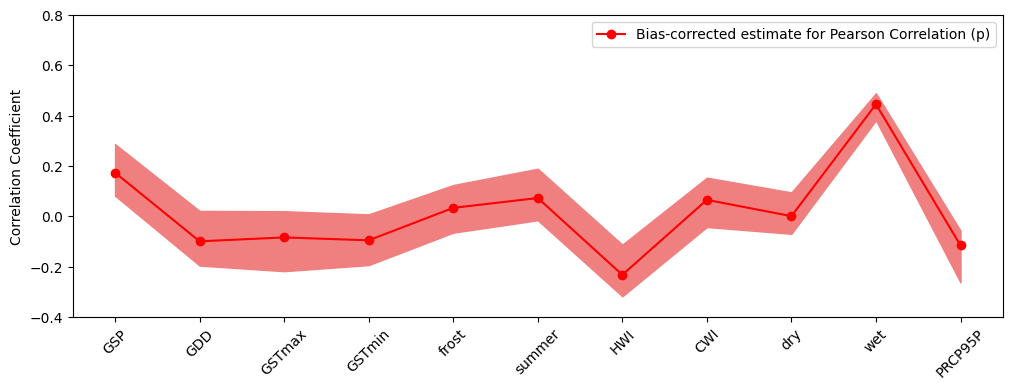

In [83]:
comb = wx.merge(corn, on='YEAR')
x = ['GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer', 'HWI', 'CWI', 'dry', 'wet', 'PRCP95P']

plt.plot(comb.YEAR, comb.Value)
plt.xlabel('Year')
plt.ylabel('Corn yield (bu/acre)')
plt.show()

#
# Normalize 
#
def norm(s):
    return (s - s.mean()) / s.std()

for f in x:
    comb[f] = norm(comb[f])
comb['Value'] = norm(comb.Value)

#
# compute the bias for each value with jackknife resampling
#
series = {}
for feat in x:
    s = []
    for n in range(0, 100):
        samples = comb.sample(frac=0.8)
        c = samples[[feat, 'Value']].corr()
        s.append(c[feat].Value)
    series[feat] = pd.Series(s)
#  
# df is all the jacknife samples
#
df = pd.DataFrame(series)

# pstar - mean of results of corr over all jackknife samples
# p     - results of running corr on original samples
# bias  - bias computed between pstar and p
# pbar  - unbiased correlation
pstar = df.mean()  
p = comb.corr().Value[x]
bias = pstar - p
pbar = p - bias

errlow = df.quantile(q=0.05)
errhigh = df.quantile(q=0.95)


plt.plot(x, pbar, '-o', color='red', label="Bias-corrected estimate for Pearson Correlation (p)")
plt.fill_between(x, errlow, errhigh, color='lightcoral')
plt.ylim(-0.4, 0.8)
plt.ylabel('Correlation Coefficient')
plt.legend()
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
